# Generation of hypothesis on regulons / pathways and processes linked to single cell -omics data

- **One line summary of the chapter**

- **Here, plus steps of the chapter**

- **Outocome of the analysis. What things can be done with these outputs.**

## What is a regulon
- **Definition of a regulon**

## How we can get a regulon
- **One of the most popular methods for this. As a general description, this test**
- **Does it work in all scenarios?**
- **What considerations should be taken for running this regulon-based analysis?**
- **Other tools to get a regulon.**

- **Given the amount of available approaches to generate regulons and/or gene regulatory networks, in this notebook we'll summarize and use two approaches for this purpose, and highlight caveats that can occur during the analyses of the data, at every possible step, and would require considerations for assessment of results at each step.**

- As a dataset, we will use
    - the 100,000 human PBMCs and the NeurIPS dataset, which contain healthy donors as well as COVID-19 patients{cite}`Schulte-Schrepping2020`.
    - Highlight another dataset the 100,000 human PBMCs and the NeurIPS dataset, which contain healthy donors as well as COVID-19 patients{cite}`Schulte-Schrepping2020`.

## Environment setup

In [ ]:
import warnings


# here verify all the relevant import that will be required.
# warnings.filterwarnings("ignore")

# import matplotlib.pyplot as plt
# import seaborn as sns
# import scanpy as sc
# import pandas as pd
# import numpy as np
# import random

# import rpy2.rinterface_lib.callbacks
# import anndata2ri
# import logging

# from rpy2.robjects import pandas2ri
# from rpy2.robjects import r

# sc.settings.verbosity = 0
# rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# pandas2ri.activate()
# anndata2ri.activate()

# %load_ext rpy2.ipython

In [ ]:
# R imports that will be required.
# %%R
# library(edgeR)
# library(MAST)

## Preprocessing of the dataset number 1

The current dataset we will be looking here is already pre-processed (previous chapters), and it contains:
- X cells, classified into N sub-types.
- More details on subpopulations and others.

First, we load the full dataset.

In [ ]:
path_to_dataset_h5ad = ''
adata = sc.read(
    path_to_dataset_h5ad
)
adata

AnnData object with n_obs × n_vars = 99049 × 46584
    obs: 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nReads_RNA', 'nReads_ALL', 'percent.mito', 'percent.hb', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'origID', 'date_of_sampling', 'DaysAfterSample0', 'experiment', 'PoolID', 'sampletag', 'hash.ID', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'RNA_snn_res.0.4', 'cluster_labels_res.0.4', 'new.order', 'id.celltype', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'nCount_SCT', 'nFeature_SCT', 'mapping.score', 'predicted.celltype.l1.COVID19.score', 'predicted.celltype.l1.COVID19', 'predicted.celltype.l2.COVID19.score', 'predicted.celltype.l2.COVID19', 'predicted.celltype.l1.citeseq.score', 'predicted.celltype.l1.citeseq', 'predicted.celltype.l2.citeseq.score', 'pre

## We will be working with batch-corrected normalized counts, to correct patient/batch effects.

In [ ]:
np.max(adata.X)

49066.0

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
# # Afterwards, we need to subset the full data to our conditions of interest. We also create cleaner metadata names. -->
# adata.obs["condition"] = adata.obs["group_per_sample"].copy()
# adata.obs["cell_identity"] = adata.obs["hemato.labels"].copy()

In [1]:
# #adata = adata[adata.obs["condition"].isin(["control", "severe"])]
# adata

<!-- We also restrict our control samples to one study (Reyes et al., Nat Med, 2020) -->

In [2]:
# adata = adata[
#     ~(
#         (adata.obs["condition"] == "control")
#         & (adata.obs["experiment"] != "Reyes et al., Nat Med, 2020")
#     )
# ]

<!-- After subsetting, we have 19 control and 10 disease patients. -->

In [ ]:
len(adata[adata.obs["condition"] == "control"].obs["donor"].cat.categories)

19

We filter cells which have less than 200 genes and genes which were found in less than 3 cells for a rudimentary quality control.

In [3]:
# sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)
# adata

## SCENIC

SCENIC is a method in R initially developed for ... It implements .... as provided by **method types**
For more details please read the original references publication{cite}`Robinson2010`.

Here, we will be using the the particular modality of SCENIC that accounts for .... . In contrast, variants of this processing can result in sligthly different results. Additionally, one should carefully assess different parameters for analyses, in order to generate sparser of broader associations between TFs and regulons..

We first
- Recipe step one. For each patient we create X clusters.
- We **step-two**.
- We **step-three**

The final output of our analysis will be a set of associations between TF-regulons, quantified by a p-value based on significance. We strongly recommend refer to **REF** for more information about interpretation of these associations.

First, we repeat the filtering step for each condition separately.

In [4]:
# severe = adata[adata.obs["condition"] == "severe"].copy()
# control = adata[adata.obs["condition"] == "control"].copy()
# severe, control

**Step one**

In [5]:
# sc.pp.filter_genes(severe, min_cells=3)
# severe

In [6]:
# sc.pp.filter_genes(control, min_cells=3)
# control

**Step two**

In [8]:
# adata_pp = severe.concatenate(control, index_unique=None)
# # adata_pp

<!-- Now, let's define the function we need to aggregate single cells into pseudo-replicates:
- `aggregate_and_filter` is a function that creates an AnnData object with 3 pseudo-replicates for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than 30 cells for the specified population. -->

aggregation of function per donor.

In [9]:
# NUM_OF_CELL_PER_DONOR = 30


# def aggregate_and_filter(
#     adata,
#     cell_identity,
#     donor_key="donor",
#     condition_key="condition",
#     cell_identity_key="cell_identity",
#     obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
#     replicates_per_patient=3,
# ):
#     # subset adata to the given cell identity
#     adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
#     # re-filter for this cell population
#     sc.pp.filter_genes(adata_cell_pop, min_cells=3)
#     # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
#     size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
#     donors_to_drop = [
#         donor
#         for donor in size_by_donor.index
#         if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
#     ]
#     df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

#     adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
#     for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
#         print(f"Processing donor {i+1} out of {len(donors)}...", end="\r")
#         if donor not in donors_to_drop:
#             adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
#             # create replicates for each donor
#             indices = list(adata_donor.obs_names)
#             random.shuffle(indices)
#             indices = np.array_split(np.array(indices), replicates_per_patient)
#             for i, rep_idx in enumerate(indices):
#                 adata_replicate = adata_donor[rep_idx]
#                 # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
#                 agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
#                 for obs in obs_to_keep:
#                     agg_dict[obs] = "first"
#                 # create a df with all genes, donor and condition info
#                 df_donor = pd.DataFrame(adata_replicate.X.A)
#                 df_donor.index = adata_replicate.obs_names
#                 df_donor.columns = adata_replicate.var_names
#                 df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
#                 # aggregate
#                 df_donor = df_donor.groupby(donor_key).agg(agg_dict)
#                 df_donor[donor_key] = donor
#                 df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]

#     # create AnnData object from the df
#     adata_cell_pop = sc.AnnData(
#         df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
#     )
#     return adata_cell_pop

Metadata info into object # We might want to look at available metadata later and therefore keep it in the AnnData object.

In [ ]:
# obs_to_keep = [
#     "donor",
#     "condition",
#     "cell_identity",
#     "platform",
#     "purification",
#     "cells",
#     "age",
#     "sex",
#     "who_per_sample",
#     "disease_stage",
#     "outcome",
# ]

We need to pass the raw counts to edgeR. Hence, we set `.X` to the `counts` layer to ensure the pseudo-replicates are created for raw counts.

In [ ]:
# adata.X = adata.layers["counts"].copy()

Running analysis on X cell type

In [12]:
# %%time
# adata_gran = aggregate_and_filter(adata_pp, "Granulocytes", obs_to_keep=obs_to_keep)
# adata_gran

** - The validy of this analysis depends highly on ... **

** - Inflating the number of TF-gene associations can saturate the regulon information.**

** - Permutations/subsampling can be used to asses the robustness of the analysis.**

We perform very basic EDA on the created pseudo-replicates to check if some patients/pseudobulks are outliers that we need to exclude not to bias the DE results.

In [ ]:
# sc.pp.pca(adata_gran)

In [ ]:
# # set categorical metadata to be indeed categorical
# adata_gran.obs["donor"] = adata_gran.obs["donor"].astype("category")
# adata_gran.obs["condition"] = adata_gran.obs["condition"].astype("category")

<!-- Next, we look at created pseudo-replicates on a PCA plot and color by all the available metadata to see if there are any confounding factors that we might want to include in the design matrix.  -->

In [13]:
# sc.pl.pca(adata_gran, color=adata_gran.obs, ncols=1, size=300, legend_loc="on data")

- Outlier..

- Additionally, PC1 is confounded by ....

In [14]:
# # exclude outliers
# adata_gran = adata_gran[~adata_gran.obs["donor"].isin(["C19-CB-0009", "C19-CB-0008"])]
# adata_gran

- Running pipeline X
- The function - `name of function` takes X and does Y. Results R

In [15]:
# %%R
# find_de_edgeR <- function(adata_){
#     # create an edgeR object with counts and grouping factor
#     y <- DGEList(assay(adata_, "X"), group = colData(adata_)$condition)
#     # filter out genes with low counts
#     print("Dimensions before subsetting:")
#     print(dim(y))
#     print("")
#     keep <- filterByExpr(y)
#     y <- y[keep, , keep.lib.sizes=FALSE]
#     print("Dimensions after subsetting:")
#     print(dim(y))
#     print("")
#     y <- calcNormFactors(y)
#     # create a design matrix: here we have multiple donors so also consider that in the design matrix
#     design <- model.matrix(~ colData(adata_)$condition + colData(adata_)$donor)
#     # when we have both condition and donor information in the design matrix, it becomes not full rank
#     # i.e. sum over condition columns minus sum over donor columns = 0
#     # so we remove the last column so the matrix has full rank again
#     design <- design[,-ncol(design)]
#     print("Head of the design matrix after removing the last column:")
#     print(head(design))
#     print("")
#     y <- estimateDisp(y, design = design)
#     fit <- glmQLFit(y, design)
#     # here we have two conditions and interested in differences between them, so look at the corresponding coefficient
#     qlf <- glmQLFTest(fit, coef=2)
#     # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
#     tt <- topTags(qlf, n = Inf)
#     print("Head of the table with the test results:")
#     print(head(tt))
#     counts = data.matrix(tt$table)
#     res = SingleCellExperiment(assays = list(counts = counts))
    
#     return(list("sc" = as(res, 'SingleCellExperiment'), "y" = y, "tt" = tt, "qlf" = qlf, "design" = design))
# }

In [16]:
# %%time
# %%R -i adata_gran -o outputs
# outputs < -find_de_edgeR(adata_gran)

In [ ]:
# %%R -o res_gran
# res_gran <- outputs$sc
# y <- outputs$y
# tt <- outputs$tt
# qlf <- outputs$qlf
# design <- outputs$design

Additionally, one could also test for X category e.g. DE-genes.

In [17]:
# %%R
# fit <- glmQLFit(y, design)
# tr <- glmTreat(fit, coef=2, lfc=1.5)
# print(head(topTags(tr)))

Having a result, we can observe the number of significant associations found, stratified by effect size.

In [18]:
# %%R
# plotMDS(y)

- Value X indicates Y.


- sparse TF-gene interactions might be harder to associate with gene.

- Metric Y is X.  

- In the plot below, we can see that ....

In [19]:
# %%R
# plotBCV(y)

- All in all, we can see that X genes have a equal or lower than Y.

- A **visualization plot** shows the effect size as a function of Y. This can be used to assess the presence of systematic biases in the data.

In [20]:
# %%R
# plotSmear(qlf, de.tags = rownames(tt$table)[which(tt$table$FDR<0.01)])

We can repeat this analysis on a cluster specific way

In [21]:
# %%time
# adata_mono = aggregate_and_filter(adata_pp, "Monocytes", obs_to_keep=obs_to_keep)
# adata_mono

We repeat basic EDA.

In [22]:
# sc.pp.pca(adata_mono)

# adata_mono.obs["donor"] = adata_mono.obs["donor"].astype("category")
# adata_mono.obs["condition"] = adata_mono.obs["condition"].astype("category")

# sc.pl.pca(adata_mono, color=adata_mono.obs, ncols=1, size=300, legend_loc="on data")

Comment on the provided visualization

In [24]:
# %%time
# %%R -i adata_mono -o outputs
# outputs < -find_de_edgeR(adata_mono)

In [ ]:
# %%R -o res_mono
# res_mono <- outputs$sc
# y <- outputs$y
# tt <- outputs$tt
# qlf <- outputs$qlf

This plot can be able to identify cluster-specific TF-regulons

In [25]:
# %%R
# plotMDS(y)

<!-- We see some low abundace genes with high bcv here. We can label those genes, but there should not be any concerns here. -->

In [26]:
# %%R
# plotBCV(y)

In [27]:
# %%R
# plotSmear(qlf, de.tags = rownames(tt$table)[which(tt$table$FDR<0.01)])

<!-- From these plots we can see that compared to granulocytes, we obtained a higher number of DE genes for monocytes. -->

<!-- We can additionally visualize results with a heatmap and a volcano plot. Each row of a heatmap corresponds to a gene and each column to a single-cell. The brighter the color is the higher is the expresion of that gene in a particular cell. Since we only plot DE genes, we would like to see clear differences in expression between the two conditions. Volcano plots are often used to visualize results of statistical testing, and they show the change in expression on the x-axis (log-fold change) and statistical significance on the y-axis (FDR-corrected p-values). We color code the genes that have FDR-corrected p-value under 0.01 and log-fold change of over 1.5 -->

<!-- We need to define an additional helper funcion to clean up the results and store it in the original AnnData object. We store the output of the edgeR analysis in `.varm` where data for genes that were not used is set to `np.nan`. -->

In [28]:
# def prep_result(adata_res, adata):
#     result = pd.DataFrame(
#         adata_res.X.T, index=adata_res.var_names, columns=adata_res.obs_names
#     )
#     result = pd.DataFrame(index=adata.var_names).join(result, how="outer")
#     result = result.T[adata.var_names].T
#     return result

In [ ]:
# res_gran

AnnData object with n_obs × n_vars = 5 × 1083

In [ ]:
# res_mono

AnnData object with n_obs × n_vars = 5 × 5461

In [ ]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5


def plot_heatmap(adata, res, cell_identity):
    res = res[(res["FDR"] < FDR) & (abs(res["logFC"]) > LOG_FOLD_CHANGE)].sort_values(
        by=["logFC"]
    )
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(
        adata[adata.obs["cell_identity"] == cell_identity].copy(),
        markers,
        groupby="condition",
        swap_axes=True,
    )

And finally we can plot the heatmaps for granulocytes and monocytes.

Plotting 233 genes...


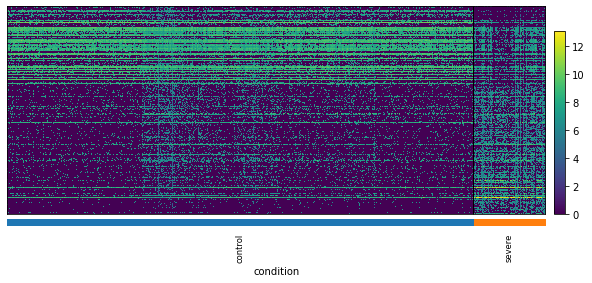

In [ ]:
plot_heatmap(adata_pp, adata_pp.varm["edgeR_granulocytes"], "Granulocytes")

Plotting 662 genes...


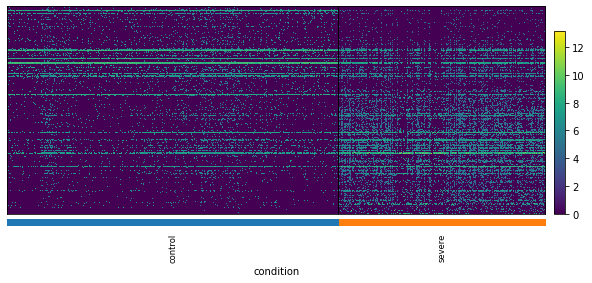

In [ ]:
plot_heatmap(adata_pp, adata_pp.varm["edgeR_monocytes"], "Monocytes")

We can see that the differences in expressions are clearer for granulocytes than for monocytes. Because there are also differences in gene expression within the cell populations (blocks of brighter/darker columns within condition), it probably indicates some substructures in both populations that are not captured but the current cell type annotation which may be interesting to investigate further.

### Notes on SCENIC:
- Requires X counts as input
- Requires labels for categories
- We recommend global and cluster specific differences, in order to tease out patterns associated to specific biological groups.

## Method 2 (ATAC+RNA)

## Key Takeaways

1. Experimental design and analysis
2. Detect global and cluster-specific regulons allows going into types of signal based on how easy and those are to be assessed as significant.
3. Statistical power is increased by generating broad gene groups with at least 100 or more genes per category. Lower gene numbers per group would dissipate the signal, and make the listing of TF-gene associations per cluster more difficult.

## Quiz

1. What is a TF-regulon and in what scenarios it might be worth discovering those?

2. What is the futility theorem? 

3. Are there more motif categories or more transcription factors? How can one reconcile the redundancy of these during the analysis?

4. How can one find cluster specific TF-regulons?

## References